In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

 # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np # linear algebra
import pandas as pd
import time
import gensim
DATA_PATH = "/home/bennis/Bureau/5GMM/AI-Frameworks/DefiIA/defi-ia-insa-toulouse"

train_df = pd.read_json(DATA_PATH+"/train.json")
train_df.set_index('Id', inplace=True) 

test_df = pd.read_json(DATA_PATH+"/test.json")
test_df.set_index('Id', inplace=True) 

train_label = pd.read_csv(DATA_PATH+"/train_label.csv")
train_label.set_index('Id', inplace=True)


#change size
#train_label = train_label[:40000]
#train_df = train_df[:40000]


categ = pd.read_csv(DATA_PATH+'/categories_string.csv')

In [13]:
#imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
#device = torch.device("cuda")
device = torch.device("cpu")

In [3]:
train_label

,Category
Id,
0,19
1,9
2,19
3,24
4,24
...,...
217192,19
217193,22
217194,19


In [4]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(train_df['description'], train_label['Category'], 
                                                                    random_state=2020, 
                                                                    test_size=0.3, 
                                                                    stratify=train_label)


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2020, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [5]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

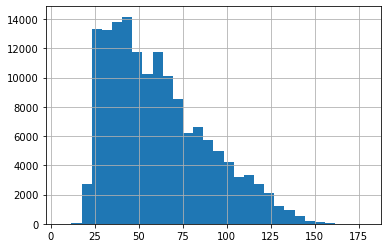

In [6]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [7]:
# We choose a max length to 100
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    padding='max_length',
    max_length = 50,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    padding='max_length',
    max_length = 50,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    padding='max_length',
    max_length = 50,
    pad_to_max_length=True,
    truncation=True
)

In [8]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [9]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 2

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [10]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [11]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
      # dropout layer
        self.dropout = nn.Dropout(0.1)
      
      # relu activation function
        self.relu =  nn.ReLU()

      # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,28)

      #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

      # output layer
        x = self.fc2(x)
      
      # apply softmax activation
        x = self.softmax(x)

        return x

In [14]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [15]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [16]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [5.18119547 1.88537946 8.21466393 0.84828821 9.61042984 1.67848311
 0.6309427  9.03476349 1.17250979 2.48507682 9.32971281 0.66829451
 4.73399552 1.91058862 0.61458889 1.80755421 1.42330088 5.5181838
 1.88080806 0.11078927 0.5296423  9.90856361 0.74647963 8.02052121
 1.32792684 2.28530844 0.41216736 3.38944623]


/usr/local/insa/anaconda/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27], y=Id
23163      9
114118    26
190671    26
109129     8
96769     14
          ..
166697    14
86562      9
198772    19
104776    19
14995     25
Name: Category, Length: 152037, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [17]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [18]:
# function to train the model
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
    total_preds=[]
  
  # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
    return avg_loss, total_preds

In [19]:
from babel.dates import format_time

In [20]:
# function for evaluating the model
import babel
def evaluate():
  
    print("\nEvaluating...")
  
  # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
    total_preds = []
    
    t0 = time.time()

  # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
      # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

    # deactivate autograd
        with torch.no_grad():
      
      # model predictions
            preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

  # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

transformers

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of  76,019.
  Batch   100  of  76,019.
  Batch   150  of  76,019.
  Batch   200  of  76,019.
  Batch   250  of  76,019.
  Batch   300  of  76,019.
  Batch   350  of  76,019.
  Batch   400  of  76,019.
  Batch   450  of  76,019.
  Batch   500  of  76,019.
  Batch   550  of  76,019.
  Batch   600  of  76,019.
  Batch   650  of  76,019.
  Batch   700  of  76,019.
  Batch   750  of  76,019.
  Batch   800  of  76,019.
  Batch   850  of  76,019.
  Batch   900  of  76,019.
  Batch   950  of  76,019.
  Batch 1,000  of  76,019.
  Batch 1,050  of  76,019.
  Batch 1,100  of  76,019.
  Batch 1,150  of  76,019.
  Batch 1,200  of  76,019.
  Batch 1,250  of  76,019.
  Batch 1,300  of  76,019.
  Batch 1,350  of  76,019.
  Batch 1,400  of  76,019.
  Batch 1,450  of  76,019.
  Batch 1,500  of  76,019.
  Batch 1,550  of  76,019.
  Batch 1,600  of  76,019.
  Batch 1,650  of  76,019.
  Batch 1,700  of  76,019.
  Batch 1,750  of  76,019.
  Batch 1,800  of  76,019.
  Batch 1,850

  Batch 16,500  of  76,019.
  Batch 16,550  of  76,019.
  Batch 16,600  of  76,019.
  Batch 16,650  of  76,019.
  Batch 16,700  of  76,019.
  Batch 16,750  of  76,019.
  Batch 16,800  of  76,019.
  Batch 16,850  of  76,019.
  Batch 16,900  of  76,019.
  Batch 16,950  of  76,019.
  Batch 17,000  of  76,019.
  Batch 17,050  of  76,019.
  Batch 17,100  of  76,019.
  Batch 17,150  of  76,019.
  Batch 17,200  of  76,019.
  Batch 17,250  of  76,019.
  Batch 17,300  of  76,019.
  Batch 17,350  of  76,019.
  Batch 17,400  of  76,019.
  Batch 17,450  of  76,019.
  Batch 17,500  of  76,019.
  Batch 17,550  of  76,019.
  Batch 17,600  of  76,019.
  Batch 17,650  of  76,019.
  Batch 17,700  of  76,019.
  Batch 17,750  of  76,019.
  Batch 17,800  of  76,019.
  Batch 17,850  of  76,019.
  Batch 17,900  of  76,019.
  Batch 17,950  of  76,019.
  Batch 18,000  of  76,019.
  Batch 18,050  of  76,019.
  Batch 18,100  of  76,019.
  Batch 18,150  of  76,019.
  Batch 18,200  of  76,019.
  Batch 18,250  of  

  Batch 33,000  of  76,019.
  Batch 33,050  of  76,019.
  Batch 33,100  of  76,019.
  Batch 33,150  of  76,019.
  Batch 33,200  of  76,019.
  Batch 33,250  of  76,019.
  Batch 33,300  of  76,019.
  Batch 33,350  of  76,019.
  Batch 33,400  of  76,019.
  Batch 33,450  of  76,019.
  Batch 33,500  of  76,019.
  Batch 33,550  of  76,019.
  Batch 33,600  of  76,019.
  Batch 33,650  of  76,019.
  Batch 33,700  of  76,019.
  Batch 33,750  of  76,019.
  Batch 33,800  of  76,019.
  Batch 33,850  of  76,019.
  Batch 33,900  of  76,019.
  Batch 33,950  of  76,019.
  Batch 34,000  of  76,019.
  Batch 34,050  of  76,019.
  Batch 34,100  of  76,019.
  Batch 34,150  of  76,019.
  Batch 34,200  of  76,019.
  Batch 34,250  of  76,019.
  Batch 34,300  of  76,019.
  Batch 34,350  of  76,019.
  Batch 34,400  of  76,019.
  Batch 34,450  of  76,019.
  Batch 34,500  of  76,019.
  Batch 34,550  of  76,019.
  Batch 34,600  of  76,019.
  Batch 34,650  of  76,019.
  Batch 34,700  of  76,019.
  Batch 34,750  of  

  Batch 48,950  of  76,019.
  Batch 49,000  of  76,019.
  Batch 49,050  of  76,019.
  Batch 49,100  of  76,019.
  Batch 49,150  of  76,019.
  Batch 49,200  of  76,019.
  Batch 49,250  of  76,019.
  Batch 49,300  of  76,019.
  Batch 49,350  of  76,019.
  Batch 49,400  of  76,019.
  Batch 49,450  of  76,019.
  Batch 49,500  of  76,019.
  Batch 49,550  of  76,019.
  Batch 49,600  of  76,019.
  Batch 49,650  of  76,019.
  Batch 49,700  of  76,019.
  Batch 49,750  of  76,019.
  Batch 49,800  of  76,019.
  Batch 49,850  of  76,019.
  Batch 49,900  of  76,019.
  Batch 49,950  of  76,019.
  Batch 50,000  of  76,019.
  Batch 50,050  of  76,019.
  Batch 50,100  of  76,019.
  Batch 50,150  of  76,019.
  Batch 50,200  of  76,019.
  Batch 50,250  of  76,019.
  Batch 50,300  of  76,019.
  Batch 50,350  of  76,019.
  Batch 50,400  of  76,019.
  Batch 50,450  of  76,019.
  Batch 50,500  of  76,019.
  Batch 50,550  of  76,019.
  Batch 50,600  of  76,019.
  Batch 50,650  of  76,019.
  Batch 50,700  of  

  Batch 63,600  of  76,019.
  Batch 63,650  of  76,019.
  Batch 63,700  of  76,019.
  Batch 63,750  of  76,019.
  Batch 63,800  of  76,019.
  Batch 63,850  of  76,019.
  Batch 63,900  of  76,019.
  Batch 63,950  of  76,019.
  Batch 64,000  of  76,019.
  Batch 64,050  of  76,019.
  Batch 64,100  of  76,019.
  Batch 64,150  of  76,019.
  Batch 64,200  of  76,019.
  Batch 64,250  of  76,019.
  Batch 64,300  of  76,019.
  Batch 64,350  of  76,019.
  Batch 64,400  of  76,019.
  Batch 64,450  of  76,019.
  Batch 64,500  of  76,019.
  Batch 64,550  of  76,019.
  Batch 64,600  of  76,019.
  Batch 64,650  of  76,019.
  Batch 64,700  of  76,019.
  Batch 64,750  of  76,019.
  Batch 64,800  of  76,019.
  Batch 64,850  of  76,019.
  Batch 64,900  of  76,019.
  Batch 64,950  of  76,019.
  Batch 65,000  of  76,019.
  Batch 65,050  of  76,019.
  Batch 65,100  of  76,019.
  Batch 65,150  of  76,019.
  Batch 65,200  of  76,019.
  Batch 65,250  of  76,019.
  Batch 65,300  of  76,019.
  Batch 65,350  of  

  Batch 2,300  of  16,290.
  Batch 2,350  of  16,290.
  Batch 2,400  of  16,290.
  Batch 2,450  of  16,290.
  Batch 2,500  of  16,290.
  Batch 2,550  of  16,290.
  Batch 2,600  of  16,290.
  Batch 2,650  of  16,290.
  Batch 2,700  of  16,290.
  Batch 2,750  of  16,290.
  Batch 2,800  of  16,290.
  Batch 2,850  of  16,290.
  Batch 2,900  of  16,290.
  Batch 2,950  of  16,290.
  Batch 3,000  of  16,290.
  Batch 3,050  of  16,290.
  Batch 3,100  of  16,290.
  Batch 3,150  of  16,290.
  Batch 3,200  of  16,290.
  Batch 3,250  of  16,290.
  Batch 3,300  of  16,290.
  Batch 3,350  of  16,290.
  Batch 3,400  of  16,290.
  Batch 3,450  of  16,290.
  Batch 3,500  of  16,290.
  Batch 3,550  of  16,290.
  Batch 3,600  of  16,290.
  Batch 3,650  of  16,290.
  Batch 3,700  of  16,290.
  Batch 3,750  of  16,290.
  Batch 3,800  of  16,290.
  Batch 3,850  of  16,290.
  Batch 3,900  of  16,290.
  Batch 3,950  of  16,290.
  Batch 4,000  of  16,290.
  Batch 4,050  of  16,290.
  Batch 4,100  of  16,290.
 

  Batch 2,400  of  76,019.
  Batch 2,450  of  76,019.
  Batch 2,500  of  76,019.
  Batch 2,550  of  76,019.
  Batch 2,600  of  76,019.
  Batch 2,650  of  76,019.
  Batch 2,700  of  76,019.
  Batch 2,750  of  76,019.
  Batch 2,800  of  76,019.
  Batch 2,850  of  76,019.
  Batch 2,900  of  76,019.
  Batch 2,950  of  76,019.
  Batch 3,000  of  76,019.
  Batch 3,050  of  76,019.
  Batch 3,100  of  76,019.
  Batch 3,150  of  76,019.
  Batch 3,200  of  76,019.
  Batch 3,250  of  76,019.
  Batch 3,300  of  76,019.
  Batch 3,350  of  76,019.
  Batch 3,400  of  76,019.
  Batch 3,450  of  76,019.
  Batch 3,500  of  76,019.
  Batch 3,550  of  76,019.
  Batch 3,600  of  76,019.
  Batch 3,650  of  76,019.
  Batch 3,700  of  76,019.
  Batch 3,750  of  76,019.
  Batch 3,800  of  76,019.
  Batch 3,850  of  76,019.
  Batch 3,900  of  76,019.
  Batch 3,950  of  76,019.
  Batch 4,000  of  76,019.
  Batch 4,050  of  76,019.
  Batch 4,100  of  76,019.
  Batch 4,150  of  76,019.
  Batch 4,200  of  76,019.
 

  Batch 19,150  of  76,019.
  Batch 19,200  of  76,019.
  Batch 19,250  of  76,019.
  Batch 19,300  of  76,019.
  Batch 19,350  of  76,019.
  Batch 19,400  of  76,019.
  Batch 19,450  of  76,019.
  Batch 19,500  of  76,019.
  Batch 19,550  of  76,019.
  Batch 19,600  of  76,019.
  Batch 19,650  of  76,019.
  Batch 19,700  of  76,019.
  Batch 19,750  of  76,019.
  Batch 19,800  of  76,019.
  Batch 19,850  of  76,019.
  Batch 19,900  of  76,019.
  Batch 19,950  of  76,019.
  Batch 20,000  of  76,019.
  Batch 20,050  of  76,019.
  Batch 20,100  of  76,019.
  Batch 20,150  of  76,019.
  Batch 20,200  of  76,019.
  Batch 20,250  of  76,019.
  Batch 20,300  of  76,019.
  Batch 20,350  of  76,019.
  Batch 20,400  of  76,019.
  Batch 20,450  of  76,019.
  Batch 20,500  of  76,019.
  Batch 20,550  of  76,019.
  Batch 20,600  of  76,019.
  Batch 20,650  of  76,019.
  Batch 20,700  of  76,019.
  Batch 20,750  of  76,019.
  Batch 20,800  of  76,019.
  Batch 20,850  of  76,019.
  Batch 20,900  of  

  Batch 35,400  of  76,019.
  Batch 35,450  of  76,019.
  Batch 35,500  of  76,019.
  Batch 35,550  of  76,019.
  Batch 35,600  of  76,019.
  Batch 35,650  of  76,019.
  Batch 35,700  of  76,019.
  Batch 35,750  of  76,019.
  Batch 35,800  of  76,019.
  Batch 35,850  of  76,019.
  Batch 35,900  of  76,019.
  Batch 35,950  of  76,019.
  Batch 36,000  of  76,019.
  Batch 36,050  of  76,019.
  Batch 36,100  of  76,019.
  Batch 36,150  of  76,019.
  Batch 36,200  of  76,019.
  Batch 36,250  of  76,019.
  Batch 36,300  of  76,019.
  Batch 36,350  of  76,019.
  Batch 36,400  of  76,019.
  Batch 36,450  of  76,019.
  Batch 36,500  of  76,019.
  Batch 36,550  of  76,019.
  Batch 36,600  of  76,019.
  Batch 36,650  of  76,019.
  Batch 36,700  of  76,019.
  Batch 36,750  of  76,019.
  Batch 36,800  of  76,019.
  Batch 36,850  of  76,019.
  Batch 36,900  of  76,019.
  Batch 36,950  of  76,019.
  Batch 37,000  of  76,019.
  Batch 37,050  of  76,019.
  Batch 37,100  of  76,019.
  Batch 37,150  of  

  Batch 52,550  of  76,019.
  Batch 52,600  of  76,019.
  Batch 52,650  of  76,019.
  Batch 52,700  of  76,019.
  Batch 52,750  of  76,019.
  Batch 52,800  of  76,019.
  Batch 52,850  of  76,019.
  Batch 52,900  of  76,019.
  Batch 52,950  of  76,019.
  Batch 53,000  of  76,019.
  Batch 53,050  of  76,019.
  Batch 53,100  of  76,019.
  Batch 53,150  of  76,019.
  Batch 53,200  of  76,019.
  Batch 53,250  of  76,019.
  Batch 53,300  of  76,019.
  Batch 53,350  of  76,019.
  Batch 53,400  of  76,019.
  Batch 53,450  of  76,019.
  Batch 53,500  of  76,019.
  Batch 53,550  of  76,019.
  Batch 53,600  of  76,019.
  Batch 53,650  of  76,019.
  Batch 53,700  of  76,019.
  Batch 53,750  of  76,019.
  Batch 53,800  of  76,019.
  Batch 53,850  of  76,019.
  Batch 53,900  of  76,019.
  Batch 53,950  of  76,019.
  Batch 54,000  of  76,019.
  Batch 54,050  of  76,019.
  Batch 54,100  of  76,019.
  Batch 54,150  of  76,019.
  Batch 54,200  of  76,019.
  Batch 54,250  of  76,019.
  Batch 54,300  of  

  Batch 69,750  of  76,019.
  Batch 69,800  of  76,019.
  Batch 69,850  of  76,019.
  Batch 69,900  of  76,019.
  Batch 69,950  of  76,019.
  Batch 70,000  of  76,019.
  Batch 70,050  of  76,019.
  Batch 70,100  of  76,019.
  Batch 70,150  of  76,019.
  Batch 70,200  of  76,019.
  Batch 70,250  of  76,019.
  Batch 70,300  of  76,019.
  Batch 70,350  of  76,019.
  Batch 70,400  of  76,019.
  Batch 70,450  of  76,019.
  Batch 70,500  of  76,019.
  Batch 70,550  of  76,019.
  Batch 70,600  of  76,019.
  Batch 70,650  of  76,019.
  Batch 70,700  of  76,019.
  Batch 70,750  of  76,019.
  Batch 70,800  of  76,019.
  Batch 70,850  of  76,019.
  Batch 70,900  of  76,019.
  Batch 70,950  of  76,019.
  Batch 71,000  of  76,019.
  Batch 71,050  of  76,019.
  Batch 71,100  of  76,019.
  Batch 71,150  of  76,019.
  Batch 71,200  of  76,019.
  Batch 71,250  of  76,019.
  Batch 71,300  of  76,019.
  Batch 71,350  of  76,019.
  Batch 71,400  of  76,019.
  Batch 71,450  of  76,019.
  Batch 71,500  of  

  Batch 8,700  of  16,290.
  Batch 8,750  of  16,290.
  Batch 8,800  of  16,290.
  Batch 8,850  of  16,290.
  Batch 8,900  of  16,290.
  Batch 8,950  of  16,290.
  Batch 9,000  of  16,290.
  Batch 9,050  of  16,290.
  Batch 9,100  of  16,290.
  Batch 9,150  of  16,290.
  Batch 9,200  of  16,290.
  Batch 9,250  of  16,290.
  Batch 9,300  of  16,290.
  Batch 9,350  of  16,290.
  Batch 9,400  of  16,290.
  Batch 9,450  of  16,290.
  Batch 9,500  of  16,290.
  Batch 9,550  of  16,290.
  Batch 9,600  of  16,290.
  Batch 9,650  of  16,290.
  Batch 9,700  of  16,290.
  Batch 9,750  of  16,290.
  Batch 9,800  of  16,290.
  Batch 9,850  of  16,290.
  Batch 9,900  of  16,290.
  Batch 9,950  of  16,290.
  Batch 10,000  of  16,290.
  Batch 10,050  of  16,290.
  Batch 10,100  of  16,290.
  Batch 10,150  of  16,290.
  Batch 10,200  of  16,290.
  Batch 10,250  of  16,290.
  Batch 10,300  of  16,290.
  Batch 10,350  of  16,290.
  Batch 10,400  of  16,290.
  Batch 10,450  of  16,290.
  Batch 10,500  of

  Batch 8,950  of  76,019.
  Batch 9,000  of  76,019.
  Batch 9,050  of  76,019.
  Batch 9,100  of  76,019.
  Batch 9,150  of  76,019.
  Batch 9,200  of  76,019.
  Batch 9,250  of  76,019.
  Batch 9,300  of  76,019.
  Batch 9,350  of  76,019.
  Batch 9,400  of  76,019.
  Batch 9,450  of  76,019.
  Batch 9,500  of  76,019.
  Batch 9,550  of  76,019.
  Batch 9,600  of  76,019.
  Batch 9,650  of  76,019.
  Batch 9,700  of  76,019.
  Batch 9,750  of  76,019.
  Batch 9,800  of  76,019.
  Batch 9,850  of  76,019.
  Batch 9,900  of  76,019.
  Batch 9,950  of  76,019.
  Batch 10,000  of  76,019.
  Batch 10,050  of  76,019.
  Batch 10,100  of  76,019.
  Batch 10,150  of  76,019.
  Batch 10,200  of  76,019.
  Batch 10,250  of  76,019.
  Batch 10,300  of  76,019.
  Batch 10,350  of  76,019.
  Batch 10,400  of  76,019.
  Batch 10,450  of  76,019.
  Batch 10,500  of  76,019.
  Batch 10,550  of  76,019.
  Batch 10,600  of  76,019.
  Batch 10,650  of  76,019.
  Batch 10,700  of  76,019.
  Batch 10,75

  Batch 24,600  of  76,019.
  Batch 24,650  of  76,019.
  Batch 24,700  of  76,019.
  Batch 24,750  of  76,019.
  Batch 24,800  of  76,019.
  Batch 24,850  of  76,019.
  Batch 24,900  of  76,019.
  Batch 24,950  of  76,019.
  Batch 25,000  of  76,019.
  Batch 25,050  of  76,019.
  Batch 25,100  of  76,019.
  Batch 25,150  of  76,019.
  Batch 25,200  of  76,019.
  Batch 25,250  of  76,019.
  Batch 25,300  of  76,019.
  Batch 25,350  of  76,019.
  Batch 25,400  of  76,019.
  Batch 25,450  of  76,019.
  Batch 25,500  of  76,019.
  Batch 25,550  of  76,019.
  Batch 25,600  of  76,019.
  Batch 25,650  of  76,019.
  Batch 25,700  of  76,019.
  Batch 25,750  of  76,019.
  Batch 25,800  of  76,019.
  Batch 25,850  of  76,019.
  Batch 25,900  of  76,019.
  Batch 25,950  of  76,019.
  Batch 26,000  of  76,019.
  Batch 26,050  of  76,019.
  Batch 26,100  of  76,019.
  Batch 26,150  of  76,019.
  Batch 26,200  of  76,019.
  Batch 26,250  of  76,019.
  Batch 26,300  of  76,019.
  Batch 26,350  of  

  Batch 40,450  of  76,019.
  Batch 40,500  of  76,019.
  Batch 40,550  of  76,019.
  Batch 40,600  of  76,019.
  Batch 40,650  of  76,019.
  Batch 40,700  of  76,019.
  Batch 40,750  of  76,019.
  Batch 40,800  of  76,019.
  Batch 40,850  of  76,019.
  Batch 40,900  of  76,019.
  Batch 40,950  of  76,019.
  Batch 41,000  of  76,019.
  Batch 41,050  of  76,019.
  Batch 41,100  of  76,019.
  Batch 41,150  of  76,019.
  Batch 41,200  of  76,019.
  Batch 41,250  of  76,019.
  Batch 41,300  of  76,019.
  Batch 41,350  of  76,019.
  Batch 41,400  of  76,019.
  Batch 41,450  of  76,019.
  Batch 41,500  of  76,019.
  Batch 41,550  of  76,019.
  Batch 41,600  of  76,019.
  Batch 41,650  of  76,019.
  Batch 41,700  of  76,019.
  Batch 41,750  of  76,019.
  Batch 41,800  of  76,019.
  Batch 41,850  of  76,019.
  Batch 41,900  of  76,019.
  Batch 41,950  of  76,019.
  Batch 42,000  of  76,019.
  Batch 42,050  of  76,019.
  Batch 42,100  of  76,019.
  Batch 42,150  of  76,019.
  Batch 42,200  of  

  Batch 56,800  of  76,019.
  Batch 56,850  of  76,019.
  Batch 56,900  of  76,019.
  Batch 56,950  of  76,019.
  Batch 57,000  of  76,019.
  Batch 57,050  of  76,019.
  Batch 57,100  of  76,019.
  Batch 57,150  of  76,019.
  Batch 57,200  of  76,019.
  Batch 57,250  of  76,019.
  Batch 57,300  of  76,019.
  Batch 57,350  of  76,019.
  Batch 57,400  of  76,019.
  Batch 57,450  of  76,019.
  Batch 57,500  of  76,019.
  Batch 57,550  of  76,019.
  Batch 57,600  of  76,019.
  Batch 57,650  of  76,019.
  Batch 57,700  of  76,019.
  Batch 57,750  of  76,019.
  Batch 57,800  of  76,019.
  Batch 57,850  of  76,019.
  Batch 57,900  of  76,019.
  Batch 57,950  of  76,019.
  Batch 58,000  of  76,019.
  Batch 58,050  of  76,019.
  Batch 58,100  of  76,019.
  Batch 58,150  of  76,019.
  Batch 58,200  of  76,019.
  Batch 58,250  of  76,019.
  Batch 58,300  of  76,019.
  Batch 58,350  of  76,019.
  Batch 58,400  of  76,019.
  Batch 58,450  of  76,019.
  Batch 58,500  of  76,019.
  Batch 58,550  of  

  Batch 71,900  of  76,019.
  Batch 71,950  of  76,019.
  Batch 72,000  of  76,019.
  Batch 72,050  of  76,019.
  Batch 72,100  of  76,019.
  Batch 72,150  of  76,019.
  Batch 72,200  of  76,019.
  Batch 72,250  of  76,019.
  Batch 72,300  of  76,019.
  Batch 72,350  of  76,019.
  Batch 72,400  of  76,019.
  Batch 72,450  of  76,019.
  Batch 72,500  of  76,019.
  Batch 72,550  of  76,019.
  Batch 72,600  of  76,019.
  Batch 72,650  of  76,019.
  Batch 72,700  of  76,019.
  Batch 72,750  of  76,019.
  Batch 72,800  of  76,019.
  Batch 72,850  of  76,019.
  Batch 72,900  of  76,019.
  Batch 72,950  of  76,019.
  Batch 73,000  of  76,019.
  Batch 73,050  of  76,019.
  Batch 73,100  of  76,019.
  Batch 73,150  of  76,019.
  Batch 73,200  of  76,019.
  Batch 73,250  of  76,019.
  Batch 73,300  of  76,019.
  Batch 73,350  of  76,019.
  Batch 73,400  of  76,019.
  Batch 73,450  of  76,019.
  Batch 73,500  of  76,019.
  Batch 73,550  of  76,019.
  Batch 73,600  of  76,019.
  Batch 73,650  of  

  Batch 10,900  of  16,290.
  Batch 10,950  of  16,290.
  Batch 11,000  of  16,290.
  Batch 11,050  of  16,290.
  Batch 11,100  of  16,290.
  Batch 11,150  of  16,290.
  Batch 11,200  of  16,290.
  Batch 11,250  of  16,290.
  Batch 11,300  of  16,290.
  Batch 11,350  of  16,290.
  Batch 11,400  of  16,290.
  Batch 11,450  of  16,290.
  Batch 11,500  of  16,290.
  Batch 11,550  of  16,290.
  Batch 11,600  of  16,290.
  Batch 11,650  of  16,290.
  Batch 11,700  of  16,290.
  Batch 11,750  of  16,290.
  Batch 11,800  of  16,290.
  Batch 11,850  of  16,290.
  Batch 11,900  of  16,290.
  Batch 11,950  of  16,290.
  Batch 12,000  of  16,290.
  Batch 12,050  of  16,290.
  Batch 12,100  of  16,290.
  Batch 12,150  of  16,290.
  Batch 12,200  of  16,290.
  Batch 12,250  of  16,290.
  Batch 12,300  of  16,290.
  Batch 12,350  of  16,290.
  Batch 12,400  of  16,290.
  Batch 12,450  of  16,290.
  Batch 12,500  of  16,290.
  Batch 12,550  of  16,290.
  Batch 12,600  of  16,290.
  Batch 12,650  of  

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
 torch.cuda.empty_cache()

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()